In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from scipy.stats import spearmanr
import re
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import cellbayesassay as cba
import pickle
import re
import attila_utils

In [2]:
fpath = '../../resources/cell-based-assays/CO28151_outcome-summary_27062023-clean.xlsx'
conc2concentration = pd.read_excel(fpath, 1).rename({'TI nr.': 'TI'}, axis=1)
cN_columns = [c for c in conc2concentration.columns if re.match('^c[1-6]$', c)]
other_columns = [c for c in conc2concentration.columns if not re.match('^c[1-6]$', c)]
conc2concentration = pd.concat([conc2concentration[other_columns], conc2concentration[cN_columns].applymap(lambda x: x * 1e-6)], axis=1)
conc2concentration['VC'] = conc2concentration.apply(lambda r: r.loc['c6'] * 1e-3 if not np.isnan(r.loc['c6']) else r.loc['c3'] * 1e-3, axis=1)
conc2concentration['LPS'] = conc2concentration['VC']
conc2concentration = conc2concentration.set_index('TI')
conc2concentration

,TI ID,name,c1,c2,c3,c4,c5,c6,VC,LPS
TI,,,,,,,,,,
TI1,2542,Amiloride,0.000100,0.000010,1.000000e-06,NaN,NaN,NaN,1.000000e-09,1.000000e-09
TI2,2543,Phenamil methanesulfonate salt,0.000100,0.000010,1.000000e-06,NaN,NaN,NaN,1.000000e-09,1.000000e-09
TI3,2538,Benzamil hydrochloride hydrate,0.000100,0.000010,1.000000e-06,NaN,NaN,NaN,1.000000e-09,1.000000e-09
TI4,2544,"5-(N,N-Dimethyl)amiloride hydrochloride",0.000100,0.000010,1.000000e-06,NaN,NaN,NaN,1.000000e-09,1.000000e-09
TI5,2540,5-(N-Ethyl-N-isopropyl)amiloride,0.000100,0.000010,1.000000e-06,NaN,NaN,NaN,1.000000e-09,1.000000e-09
TI6,2541,"5-(N,N-Hexamethylene)amiloride",0.000010,0.000001,2.000000e-07,NaN,NaN,NaN,2.000000e-10,2.000000e-10
TI7,2539,5-(N-Methyl-N-isobutyl)amiloride,0.000100,0.000010,1.000000e-06,NaN,NaN,NaN,1.000000e-09,1.000000e-09
TI8,2719,NS 383,0.000100,0.000010,1.000000e-06,NaN,NaN,NaN,1.000000e-09,1.000000e-09
TI9,2703,A-317567,0.000100,0.000010,1.000000e-06,NaN,NaN,NaN,1.000000e-09,1.000000e-09


In [3]:
control_TIl = [
    'VC',
    'VC',
    'LPS',
    'VC',
    'VC'
]

experimentl = [
    'Aβ clearance (BV2 cells)',
    'Aβ release (H4 cells)',
    'LPS neuroinflammation (BV2 cells)',
    'Tau phoshorylation',
    'Trophic factor withdrawal (primary neurons)'
              ]
experimentd = dict(zip(experimentl, np.arange(len(experimentl))))
treatmentd = {
    'TI11': 'DIM-C-pPhOCH3',
    'TI12': 'C-DIM12',
}
fpath = '../../resources/cell-based-assays/CO28151_data-summary-clean.xlsx'

In [4]:
def extract_TI_exp_data(experiment, TI, control_TI='VC', batchvars=['Batch', 'Plate'], experimentd=experimentd, fpath=fpath):
    data = pd.read_excel(fpath, experimentd[experiment])
    TI_data = data.loc[data.TI == TI]
    # ensure that all treatment TI data are from the same batch:plate
    if len(TI_data.groupby(batchvars)) != 1:
        print('treatment with multiple batches')
        return(None)
    b = data.Plate == TI_data.iloc[0].loc['Plate']
    # if there's no information on the
    if not TI_data.iloc[0].isna().loc['Batch']:
        b = b & (data.Batch == data.iloc[0].loc['Batch'])
    TI_exp_data = data.loc[b]
    TI_exp_data_control = TI_exp_data.loc[TI_exp_data.TI == control_TI].copy()
    # if there's no control for the same batch:plate, use controls from all other batch:plate combinations
    if len(TI_exp_data_control) == 0:
        TI_exp_data_control = data.loc[data.TI == control_TI].copy()
    TI_exp_data_control['conc'] = control_TI
    TI_exp_data_TI = TI_exp_data.loc[TI_exp_data.TI == TI].copy()
    TI_exp_data = pd.concat([TI_exp_data_control, TI_exp_data_TI], axis=0)
    return(TI_exp_data)

experiment = experimentl[0]
TI = list(treatmentd.keys())[0]

def add_concentrations(df, conc2concentration=conc2concentration):
    df['concentration'] = df.conc.apply(lambda x: conc2concentration.loc[TI, x])
    df['conc_log10'] = df.concentration.apply(lambda x: np.log10(x))
    return(df)

def process_TI_list_exp(experiment, control_TI='VC', TI_list=['TI11', 'TI12'], conc2concentration=conc2concentration):
    d = {TI: add_concentrations(extract_TI_exp_data(experiment, TI, control_TI)) for TI in TI_list}
    return(d)

datad1 = pickle.load(open('../../results/2023-09-26-cell-bayes-assays/data.nc', 'rb'))

key2key_data1 = {
    'Aβ clearance (BV2 cells)': 'Abeta clearance',
    'Aβ release (H4 cells)': 'Abeta release',
    'LPS neuroinflammation (BV2 cells)': 'LPS',
    'Tau phoshorylation': 'Tau phosphorylation',
    'Trophic factor withdrawal (primary neurons)': 'GF withdrawal',
}

datad = {experiment: process_TI_list_exp(experiment, control_TI=cTI) for experiment, cTI in zip(experimentl, control_TIl)}

for key, key1 in key2key_data1.items():
    df = datad1[key1]
    datad[key].update({'TI26': df.loc[~ df.TI.isin(['TI21', 'TI22'])]})

In [5]:
datad[experimentl[2]]['TI11']

,Batch,Plate,Group,IRN,TI,conc,IL-10,IL-1β,IL-6,KC/GRO,TNF-α,concentration,conc_log10
198,NaN,4,LPS4,LPS only_4_1,LPS,LPS,5.32,0.970,15870.00,7.12,2305.00,2.000000e-10,-9.69897
199,NaN,4,LPS4,LPS only_4_2,LPS,LPS,6.64,1.120,15699.00,8.28,2077.00,2.000000e-10,-9.69897
200,NaN,4,LPS4,LPS only_4_3,LPS,LPS,5.04,1.450,23221.00,11.43,2144.00,2.000000e-10,-9.69897
201,NaN,4,LPS4,LPS only_4_4,LPS,LPS,5.60,1.230,24675.00,12.98,2140.00,2.000000e-10,-9.69897
202,NaN,4,LPS4,LPS only_4_5,LPS,LPS,5.93,1.040,15448.00,6.90,1710.00,2.000000e-10,-9.69897
203,NaN,4,LPS4,LPS only_4_6,LPS,LPS,5.56,0.650,13198.00,8.96,1915.00,2.000000e-10,-9.69897
384,NaN,4,LPS4,LPS 4_1,LPS,LPS,3.58,0.605,5805.00,2.88,956.00,2.000000e-10,-9.69897
385,NaN,4,LPS4,LPS 4_2,LPS,LPS,4.37,0.668,9036.00,4.71,1274.00,2.000000e-10,-9.69897
386,NaN,4,LPS4,LPS 4_3,LPS,LPS,4.33,0.396,8716.00,3.04,1300.00,2.000000e-10,-9.69897
387,NaN,4,LPS4,LPS 4_4,LPS,LPS,4.81,0.699,8811.00,4.37,1335.00,2.000000e-10,-9.69897


In [6]:
datad[experimentl[0]]['TI26']

,plate,Group,IRN,TI,conc,Aβ42 SN,Aβ42 Ly,concentration,conc_log10
48,5.0,E1,TI26_c1_1,TI26,1.0,10597.0,21098.0,1.000000e-05,-5.000000
49,5.0,E1,TI26_c1_2,TI26,1.0,10534.0,10094.0,1.000000e-05,-5.000000
50,5.0,E1,TI26_c1_3,TI26,1.0,16911.0,9621.0,1.000000e-05,-5.000000
51,5.0,E1,TI26_c1_4,TI26,1.0,13471.0,23356.0,1.000000e-05,-5.000000
52,5.0,E1,TI26_c1_5,TI26,1.0,15142.0,12718.0,1.000000e-05,-5.000000
53,5.0,E1,TI26_c1_6,TI26,1.0,6527.0,10961.0,1.000000e-05,-5.000000
56,5.0,E2,TI26_c2_1,TI26,2.0,6986.0,7214.0,3.000000e-06,-5.522879
57,5.0,E2,TI26_c2_2,TI26,2.0,8383.0,11977.0,3.000000e-06,-5.522879
58,5.0,E2,TI26_c2_3,TI26,2.0,10250.0,27115.0,3.000000e-06,-5.522879
59,5.0,E2,TI26_c2_4,TI26,2.0,9977.0,36650.0,3.000000e-06,-5.522879


### Aβ clearance (BV2 cells)

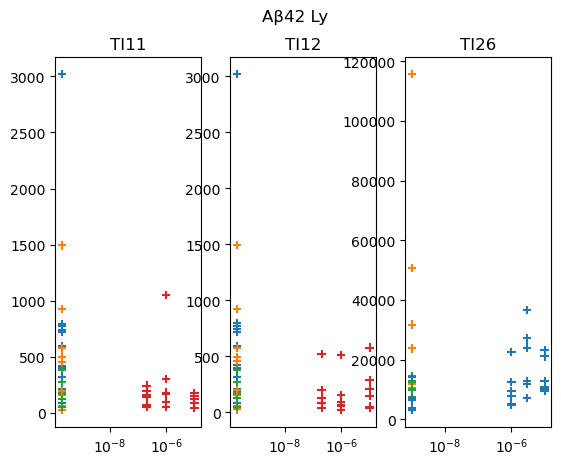

In [7]:
def data_plotter(assay, data, group_var=None, sharey=True):
    my_treatments = data.keys()
    fig, ax = plt.subplots(1, len(my_treatments), sharey=sharey)
    for axi, compound in zip(ax, my_treatments):
        df = data[compound].copy()
        if group_var is not None:
            groups = df[group_var].unique()
            groupd = dict(zip(groups, ['C' + str(i) for i in range(len(groups))]))
            df['color'] = df[group_var].apply(lambda x: groupd[x])
        else:
            df['color'] = 'C0'
        #df['color'] = 'C0'
        axi.scatter(x='concentration', y=assay, c='color', data=df, marker='+')
        axi.set_xscale('log')
        axi.set_title(compound)
    fig.suptitle(assay)
    return((fig, ax))

experiment = 'Aβ clearance (BV2 cells)'
datad[experiment]['TI26'] = datad[experiment]['TI26'].rename({'plate': 'Plate'}, axis=1)
fig, ax = data_plotter('Aβ42 Ly', datad[experiment], group_var='Plate', sharey=False)

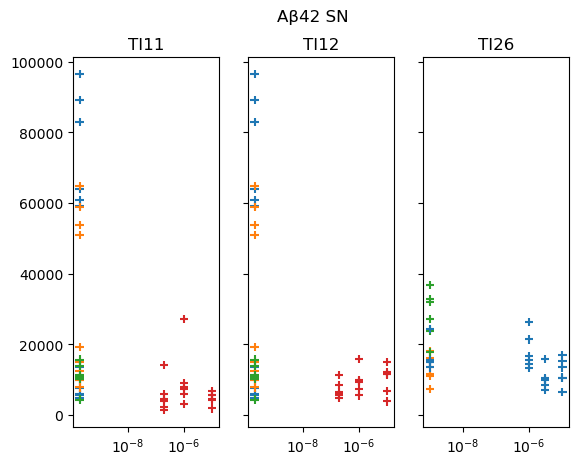

In [8]:
fig, ax = data_plotter('Aβ42 SN', datad[experiment], group_var='Plate')

### Aβ release (H4 cells)

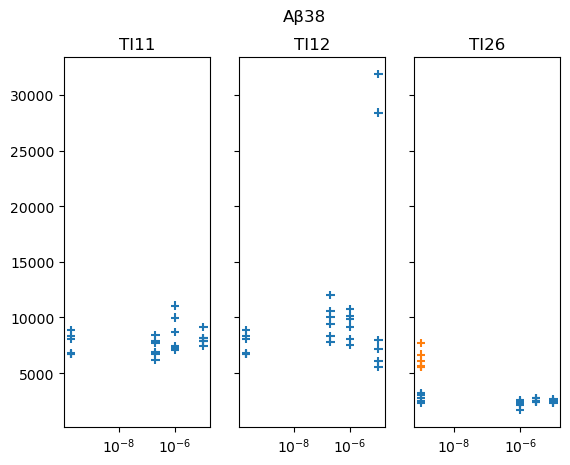

In [9]:
experiment = 'Aβ release (H4 cells)'
datad[experiment]['TI26'] = datad[experiment]['TI26'].rename({'plate': 'Plate'}, axis=1)
fig, ax = data_plotter('Aβ38', datad[experiment], group_var='Plate', sharey=True)

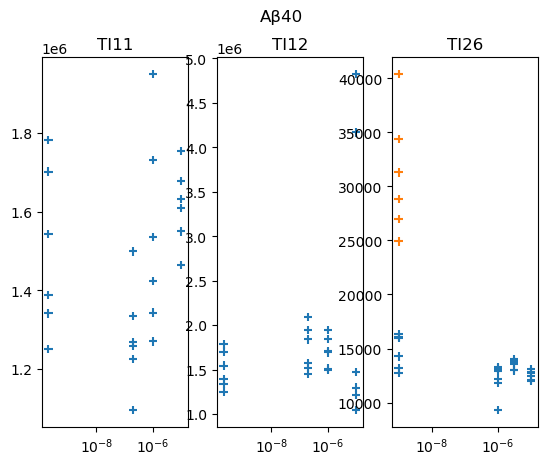

In [10]:
fig, ax = data_plotter('Aβ40', datad[experiment], group_var='Plate', sharey=False)

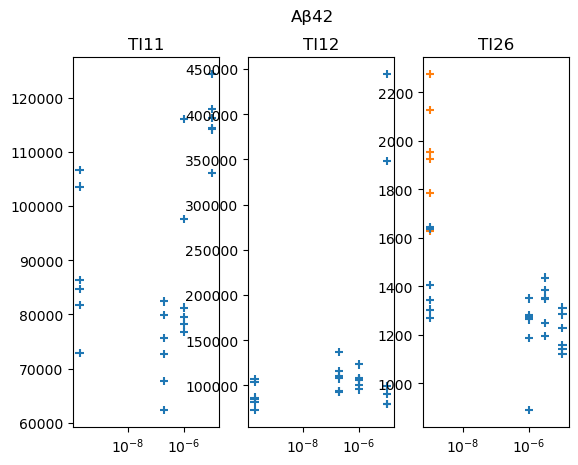

In [11]:
fig, ax = data_plotter('Aβ42', datad[experiment], group_var='Plate', sharey=False)

### LPS neuroinflammation (BV2 cells)

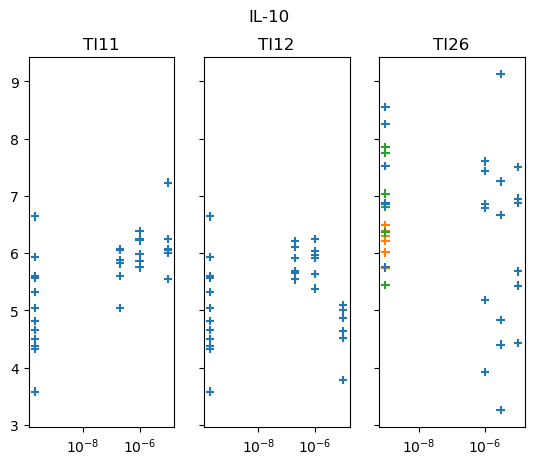

In [12]:
experiment = 'LPS neuroinflammation (BV2 cells)'
datad[experiment]['TI26'] = datad[experiment]['TI26'].rename({'Cohort': 'Plate'}, axis=1)
fig, ax = data_plotter('IL-10', datad[experiment], group_var='Plate', sharey=True)

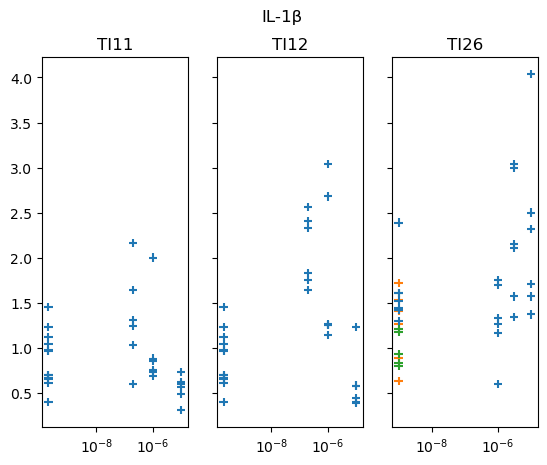

In [13]:
fig, ax = data_plotter('IL-1β', datad[experiment], group_var='Plate', sharey=True)

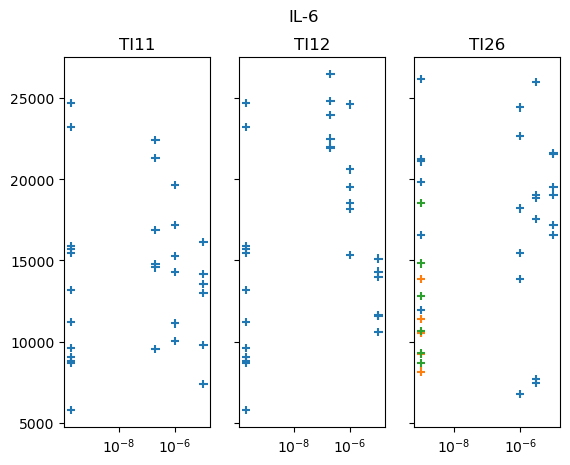

In [14]:
fig, ax = data_plotter('IL-6', datad[experiment], group_var='Plate', sharey=True)

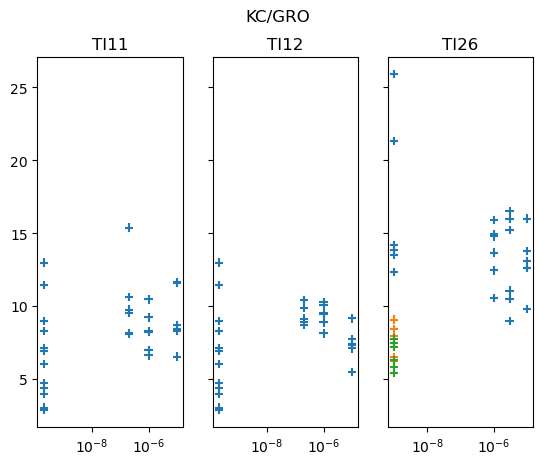

In [15]:
fig, ax = data_plotter('KC/GRO', datad[experiment], group_var='Plate', sharey=True)

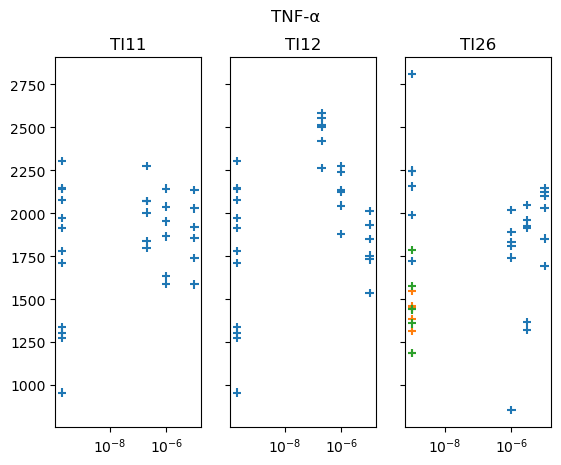

In [16]:
fig, ax = data_plotter('TNF-α', datad[experiment], group_var='Plate', sharey=True)

### Tau phoshorylation

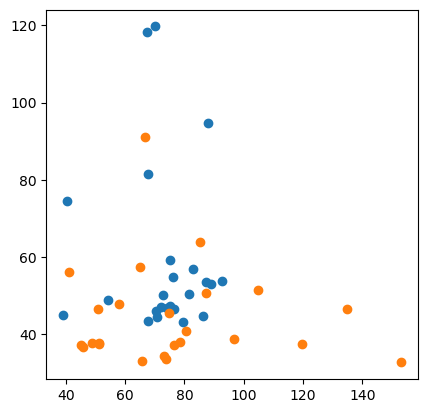

In [17]:
experiment = 'Tau phoshorylation'

fig, ax = plt.subplots(figsize=(4.8, 4.8))
ax.scatter(x='pTau (T231) [AU]', y='pTau (T231) [AU2]', data=datad[experiment]['TI11'], label='TI11')
ax.scatter(x='pTau (T231) [AU]', y='pTau (T231) [AU2]', data=datad[experiment]['TI12'], label='TI12')
#ax.scatter(x='pTau (T231) [AU]', y='pTau (T231) [AU2]', data=datad[experiment]['TI26'], label='TI26')


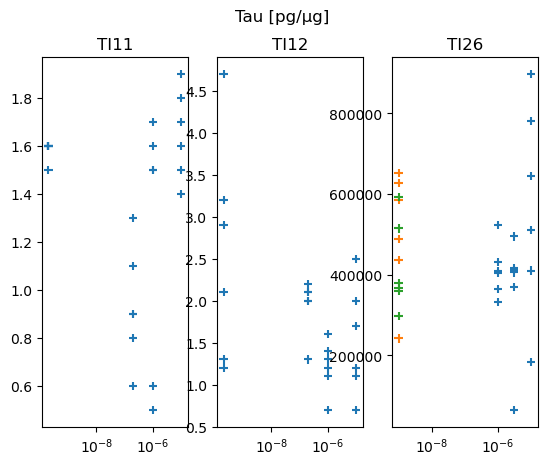

In [18]:
experiment = 'Tau phoshorylation'
datad[experiment]['TI26'] = datad[experiment]['TI26'].rename({'Cohort': 'Plate', 'Tau [pg/µg prot]': 'Tau [pg/µg]', 'pTau (T231)': 'pTau (T231) [AU2]'}, axis=1)
for TI in ['TI11', 'TI12']:
    datad[experiment][TI] = datad[experiment][TI].rename({'Ratio pTau /Tau': 'ratio'}, axis=1)

#datad[experiment]['TI11'] = datad[experiment]['TI11'].rename({'Ratio pTau /Tau': 'ratio'}, axis=1)
#datad[experiment]['TI11'] = datad[experiment]['TI11'].rename({'Ratio pTau /Tau': 'ratio'}, axis=1)

fig, ax = data_plotter('Tau [pg/µg]', datad[experiment], group_var='Plate', sharey=False)

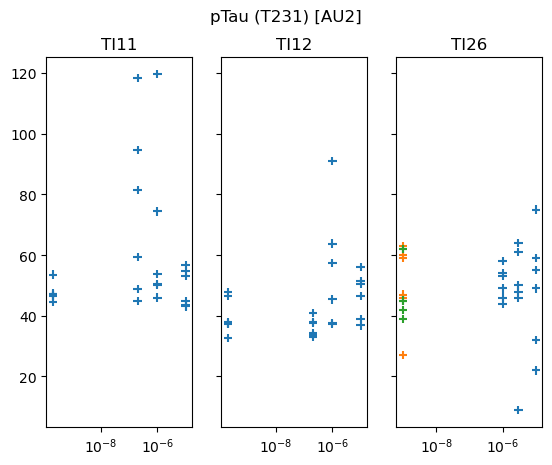

In [19]:
fig, ax = data_plotter('pTau (T231) [AU2]', datad[experiment], group_var='Plate', sharey=True)

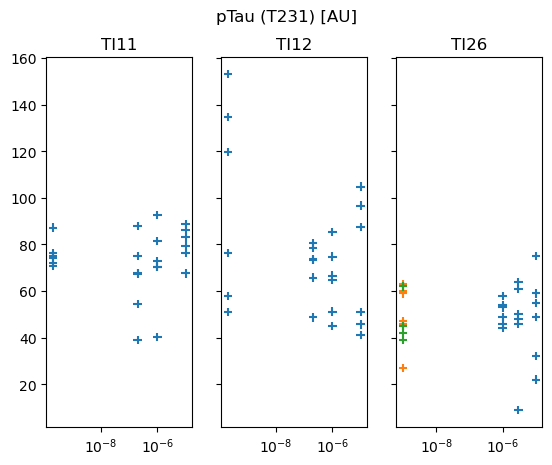

In [20]:
datad[experiment]['TI26'] = datad[experiment]['TI26'].rename({'pTau (T231) [AU2]': 'pTau (T231) [AU]'}, axis=1)
fig, ax = data_plotter('pTau (T231) [AU]', datad[experiment], group_var='Plate', sharey=True)

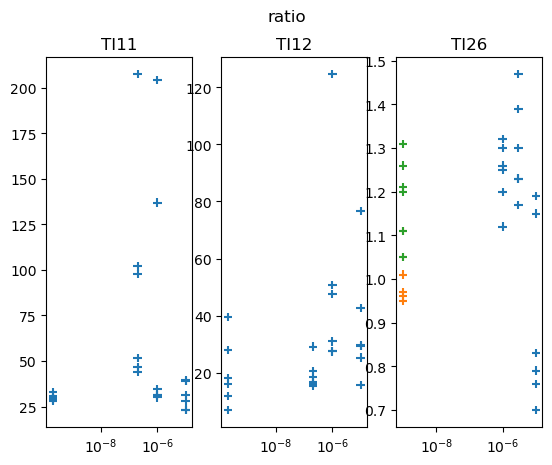

In [21]:
#datad[experiment]['TI26'] = datad[experiment]['TI26'].rename({'pTau (T231) [AU2]': 'pTau (T231) [AU1]'}, axis=1)
fig, ax = data_plotter('ratio', datad[experiment], group_var='Plate', sharey=False)

### Trophic factor withdrawal (primary neurons)

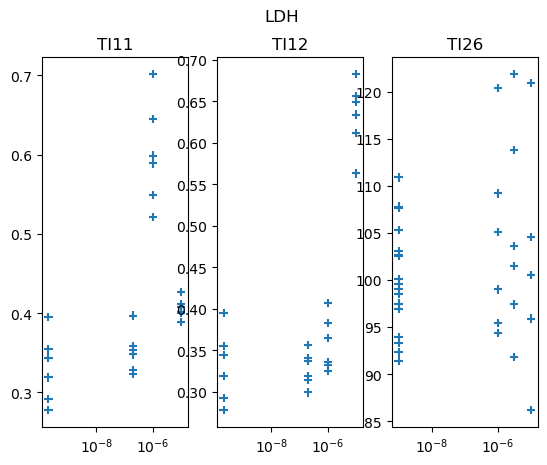

In [22]:
experiment = 'Trophic factor withdrawal (primary neurons)'
fig, ax = data_plotter('LDH', datad[experiment], group_var=None, sharey=False)

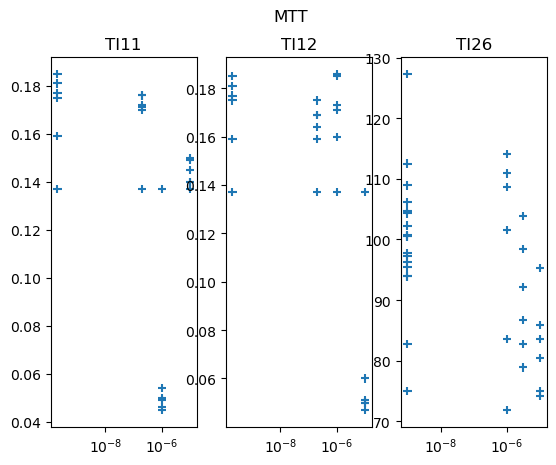

In [23]:
experiment = 'Trophic factor withdrawal (primary neurons)'
fig, ax = data_plotter('MTT', datad[experiment], group_var=None, sharey=False)

In [24]:
def extract_regr_data(exper, assay, TI, datad=datad):
    data = datad[exper][TI]
    activity = data[assay] / data[assay].std() * 10 # standardization
    data = pd.concat([data, activity.to_frame('activity')], axis=1)
    y_obs = data['activity'].values
    x_obs = data['conc_log10'].values
    return((y_obs, x_obs))

extract_regr_data('Aβ clearance (BV2 cells)', 'Aβ42 Ly', 'TI11')

(array([14.57514968,  4.13619113,  8.23298995,  7.85876314,  3.54530668,
         1.61508415,  1.18176889,  9.72989722, 18.19924095,  3.07259912,
         0.49240371,  0.55149215,  3.2695606 ,  3.44682594,  2.42262623,
         0.98480741,  5.37704846,  7.50423247,  6.26337513, 14.14183442,
        15.61904553, 11.6404236 , 15.14633798, 59.54145606, 29.38665314,
         8.98144359,  3.8407489 , 11.30558908,  0.90602282,  1.61508415,
         2.91502994,  1.77265334,  3.40743364,  2.42262623,  3.54530668,
         5.92854061,  3.24986446,  0.94541511,  1.89083023, 20.68095563,
         2.83624534,  0.94541511,  3.76196431,  3.17107986,  4.76646787,
         1.41812267]),
 array([-9.69897, -9.69897, -9.69897, -9.69897, -9.69897, -9.69897,
        -9.69897, -9.69897, -9.69897, -9.69897, -9.69897, -9.69897,
        -9.69897, -9.69897, -9.69897, -9.69897, -9.69897, -9.69897,
        -9.69897, -9.69897, -9.69897, -9.69897, -9.69897, -9.69897,
        -9.69897, -9.69897, -9.69897, -9.69897, 

In [25]:
def fit_sigmoid_2(exper, assay, TI, datad=datad):
    y_obs, x_obs = extract_regr_data(exper, assay, TI, datad=datad)
    val = cba.sample_sigmoid_2(y_obs, x_obs, return_model=False)
    return(val)

val = fit_sigmoid_2('Aβ clearance (BV2 cells)', 'Aβ42 Ly', 'TI26')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [26]:
%connect_info

{
  "shell_port": 59457,
  "iopub_port": 59458,
  "stdin_port": 59459,
  "control_port": 59461,
  "hb_port": 59460,
  "ip": "127.0.0.1",
  "key": "6e42e8f7-8f9a23470d7477b85bcd4009",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-4f732669-0549-4e8c-a702-948be6589a67.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
